In [133]:
#importing pandas and matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#setting the options on pandas number formatting and display
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_row', 700)

In [134]:
#loading rounds2.csv and checking the number of unique companies in rounds2
rounds2 = pd.read_csv("rounds2.csv", encoding = 'ISO-8859-1')
rounds2["company_permalink"] = rounds2["company_permalink"].str.lower()

unique_companies_rounds2 = rounds2['company_permalink'].nunique(dropna = True)
print("Number of unique companies in rounds2: ", unique_companies_rounds2)

Number of unique companies in rounds2:  66370


In [135]:
#loading companies.txt and checking the number of unique companies in companies
companies = pd.read_csv('companies.txt', delimiter="\t",encoding = 'ISO-8859-1')
companies["permalink"] = companies["permalink"].str.lower()

unique_companies = companies['permalink'].nunique(dropna = True)
print("Number of unique companies in companies: ", unique_companies)

Number of unique companies in companies:  66368


In [136]:
#merging the two datasets
#we use inner join to have list of common companies between the 2 datasets. If we use left join, our merged dataset 
#will have companies with empty values of country_code, category_list etc. which will not be beneficial 
#for our analysis going forward

master_frame = rounds2.merge(companies, how='inner', left_on='company_permalink', right_on='permalink')
master_frame.shape

(114942, 16)

In [137]:
#Cleaning the dataset

#Removing null values from raised_amount_usd
master_frame = master_frame[pd.notnull(master_frame['raised_amount_usd'])]

#check if there are any null values
master_frame['raised_amount_usd'].isnull().values.sum()

0

In [138]:
#Calculate the most representative value of the investment amount for each of the four funding types 
#(venture, angel, seed, and private equity) 


#calculating the count of investments by funding type.
totalInvCount = master_frame[['funding_round_type']].count()
ventureInvCount = master_frame[['funding_round_type']][master_frame.funding_round_type == 'venture'].count()
angelInvCount = master_frame[['funding_round_type']][master_frame.funding_round_type == 'angel'].count()
seedInvCount = master_frame[['funding_round_type']][master_frame.funding_round_type == 'seed'].count()
peInvCount = master_frame[['funding_round_type']][master_frame.funding_round_type == 'private_equity'].count()

#calculating the representative value of investment by type of funding
ventureAvg = master_frame[master_frame['funding_round_type'] == "venture"][["raised_amount_usd"]].mean().round()
angelAvg = master_frame[master_frame['funding_round_type'] == "angel"][["raised_amount_usd"]].mean().round()
seedAvg = master_frame[master_frame['funding_round_type'] == "seed"][["raised_amount_usd"]].mean().round()
peAvg = master_frame[master_frame['funding_round_type'] == "private_equity"][["raised_amount_usd"]].mean().round()

print("Total count of investments: ", totalInvCount[0])
print("Total count of venture investments: ", ventureInvCount[0])
print("Total count of angel investments: ", angelInvCount[0])
print("Total count of seed investments: ", seedInvCount[0])
print("Total count of pe investments: ", peInvCount[0])

print("Representative value of venture investments: ", ventureAvg[0])
print("Representative value of angel investments: ", angelAvg[0])
print("Representative value of seed investments: ", seedAvg[0])
print("Representative value of private equity investments: ", peAvg[0])



Total count of investments:  94958
Total count of venture investments:  50228
Total count of angel investments:  4860
Total count of seed investments:  23602
Total count of pe investments:  1936
Representative value of venture investments:  11748949.0
Representative value of angel investments:  958694.0
Representative value of seed investments:  719780.0
Representative value of private equity investments:  73308593.0


In [139]:
#From the above analysis, it seems that "venture" is the most suitable investment type for Spark Funds. 
#This is due to following reason

#1. Investments in venture fall beween the USD 5-15mn range specified by Spark Funds

In [140]:
#Filtering the dataset for "venture" investment type
master_frame = master_frame[master_frame.funding_round_type == 'venture']

In [141]:
#creating the top9 dataframe sorted based on the raised_amount_usd (descending) and grouped by country_code
top9 = master_frame[['raised_amount_usd','country_code']].groupby('country_code').sum().sort_values(by = ['raised_amount_usd'], ascending = False).head(9)

top9.head()

,raised_amount_usd
country_code,
USA,422510842796.00
CHN,39835418773.00
GBR,20245627416.00
IND,14391858718.00
CAN,9583332317.00


In [142]:
#shortlisting the top3 English speaking countries
#As per the wikipedia page, we shortlist the top 3 English speaking countries as - USA, GBR and IND

In [143]:
#updating the master_frame with the shortlisted top 3 English speaking countries
master_frame = master_frame[master_frame['country_code'].isin(['USA', 'GBR', 'IND'])]

In [144]:
#Removing null values from category_list
master_frame = master_frame[pd.notnull(master_frame['category_list'])]

In [145]:
#Creating the 'primary_sector' column
master_frame['primary_sector'] = master_frame.apply(lambda row: row['category_list'].split('|')[0], axis=1)

In [146]:
#loading and working on the mapping.csv file

sector_mapping = pd.read_csv("mapping.csv", encoding = 'ISO-8859-1')

#Found out that the category_list values have '0' instead of 'na'. Need to correct the error.
sector_mapping.category_list.unique()

#Correcting the 0 and na error
sector_mapping = sector_mapping.replace(regex='^0',value='Na')
sector_mapping = sector_mapping.replace(regex='0',value='na')
sector_mapping = sector_mapping.replace(regex = "2.na",value='2.0')

sector_mapping = sector_mapping.melt(id_vars="category_list",var_name="master_category")

# Removing the rows with 0 values as you are interested in only rows with value=1
sector_mapping = sector_mapping.loc[~(sector_mapping["value"]==0) ]
sector_mapping = sector_mapping.drop(columns="value")


In [147]:
#building the main_sector column in master_frame by mapping from the sector_mapping dataframe
master_frame['main_sector'] = master_frame['primary_sector'].map(sector_mapping.set_index('category_list')['master_category'])
master_frame.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,Media,Entertainment
10,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,09-11-2015,20000000.00,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,Analytics,"Social, Finance, Analytics, Advertising"
11,/organization/0xdata,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,03-01-2013,1700000.00,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,Analytics,"Social, Finance, Analytics, Advertising"
12,/organization/0xdata,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,19-07-2014,8900000.00,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,Analytics,"Social, Finance, Analytics, Advertising"
22,/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,5000000.00,/organization/1-mainstream,1 Mainstream,http://www.1mainstream.com,Apps|Cable|Distribution|Software,acquired,USA,CA,SF Bay Area,Cupertino,01-03-2012,Apps,"News, Search and Messaging"


In [148]:
#Removing rows with null values from main_sector
master_frame = master_frame[pd.notnull(master_frame['main_sector'])]

In [149]:
#creating D1
D1 = master_frame[(master_frame['country_code'] == "USA") & (master_frame['raised_amount_usd'] >= 5000000) & (master_frame['raised_amount_usd'] <= 15000000)]

#creating D2
D2 = master_frame[(master_frame['country_code'] == "GBR") & (master_frame['raised_amount_usd'] >= 5000000) & (master_frame['raised_amount_usd'] <= 15000000)]

#creating D3
D3 = master_frame[(master_frame['country_code'] == "IND") & (master_frame['raised_amount_usd'] >= 5000000) & (master_frame['raised_amount_usd'] <= 15000000)]

In [150]:
#creating D1 total_count and sum for investments by sector
D1['total_count'] = D1.apply(lambda row: D1.loc[D1.main_sector == row['main_sector'], "main_sector"].count(), axis=1)
D1['sum'] = D1.groupby('main_sector')['raised_amount_usd'].transform('sum')

/Users/ankurdhamija/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ankurdhamija/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [151]:
#creating D2 total_count and sum for investments by sector
D2['total_count'] = D2.apply(lambda row: D2.loc[D2.main_sector == row['main_sector'], "main_sector"].count(), axis=1)
D2['sum'] = D2.groupby('main_sector')['raised_amount_usd'].transform('sum')

/Users/ankurdhamija/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ankurdhamija/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [152]:
#creating D3 total_count and sum for investments by sector
D3['total_count'] = D3.apply(lambda row: D3.loc[D3.main_sector == row['main_sector'], "main_sector"].count(), axis=1)
D3['sum'] = D3.groupby('main_sector')['raised_amount_usd'].transform('sum')

/Users/ankurdhamija/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ankurdhamija/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
#total count of investments - D1
D1.shape[0]

12063

In [154]:
#total count of investments - D2
D2.shape[0]

621

In [155]:
#total count of investments - D3
D3.shape[0]

328

In [156]:
#total amount of investment - D1
D1[['raised_amount_usd']].sum()[0]

107757097294.0

In [157]:
#total amount of investment - D2
D2[['raised_amount_usd']].sum()[0]

5379078691.0

In [158]:
#total amount of investment - D3
D3[['raised_amount_usd']].sum()[0]

2949543602.0

In [159]:
#top sector based on count of investments - D1
D1 = D1.sort_values(by = ['total_count','raised_amount_usd'], ascending = (False, False)).reset_index(drop = True)

D1_unique = D1.drop_duplicates('main_sector')
D1_unique = D1_unique.sort_values(by = ['total_count'], ascending = (False)).reset_index(drop = True)
D1_unique.head()

first_sector_D1 = D1_unique.at[0,"main_sector"]
second_sector_D1 = D1_unique.at[1,"main_sector"]
third_sector_D1 = D1_unique.at[2,"main_sector"]

print("Top Sector for country D1:", first_sector_D1)
print("Second sector for country D1:", second_sector_D1)
print("Third sector for country D1: ", third_sector_D1)

#number of investments by sector
first_sector_D1_inv_count = D1[D1.main_sector == first_sector_D1].reset_index().loc[0,"total_count"]
second_sector_D1_inv_count = D1[D1.main_sector == second_sector_D1].reset_index().loc[0,"total_count"]
third_sector_D1_inv_count = D1[D1.main_sector == third_sector_D1].reset_index().loc[0,"total_count"]

print("Number of investments in top sector: ", first_sector_D1_inv_count)
print("Number of investments in second sector: ", second_sector_D1_inv_count)
print("Number of investments in third sector: ", third_sector_D1_inv_count)

#companies with highest amount of funding
print(D1[D1.main_sector == first_sector_D1].sort_values(by = ['raised_amount_usd'], ascending = (False)).reset_index().loc[0,"name"])
print(D1[D1.main_sector == second_sector_D1].sort_values(by = ['raised_amount_usd'], ascending = (False)).reset_index().loc[0,"name"])
C1 = D1.loc[0,["country_code"]].country_code

Top Sector for country D1: Others
Second sector for country D1: Social, Finance, Analytics, Advertising
Third sector for country D1:  Cleantech / Semiconductors
Number of investments in top sector:  2950
Number of investments in second sector:  2714
Number of investments in third sector:  2350
1stdibs
Admeld


In [160]:
#top sector based on count of investments - D2
D2.head()

D2 = D2.sort_values(by = ['total_count','raised_amount_usd'], ascending = (False, False)).reset_index(drop = True)

D2_unique = D2.drop_duplicates('main_sector')
D2_unique = D2_unique.sort_values(by = ['total_count'], ascending = (False)).reset_index(drop = True)
D2_unique.head()

first_sector_D2 = D2_unique.at[0,"main_sector"]
second_sector_D2 = D2_unique.at[1,"main_sector"]
third_sector_D2 = D2_unique.at[2,"main_sector"]

print("Top Sector for country D2:", first_sector_D2)
print("Second sector for country D2:", second_sector_D2)
print("Third sector for country D2: ", third_sector_D2)

#number of investments by sector
first_sector_D2_inv_count = D2[D2.main_sector == first_sector_D2].reset_index().loc[0,"total_count"]
second_sector_D2_inv_count = D2[D2.main_sector == second_sector_D2].reset_index().loc[0,"total_count"]
third_sector_D2_inv_count = D2[D2.main_sector == third_sector_D2].reset_index().loc[0,"total_count"]

print("Number of investments in top sector: ", first_sector_D2_inv_count)
print("Number of investments in second sector: ", second_sector_D2_inv_count)
print("Number of investments in third sector: ", third_sector_D2_inv_count)


#companies with highest amount of funding
print(D2[D2.main_sector == first_sector_D2].sort_values(by = ['raised_amount_usd'], ascending = (False)).reset_index().loc[0,"name"])
print(D2[D2.main_sector == second_sector_D2].sort_values(by = ['raised_amount_usd'], ascending = (False)).reset_index().loc[0,"name"])
C2 = D2.loc[0,["country_code"]].country_code

Top Sector for country D2: Others
Second sector for country D2: Social, Finance, Analytics, Advertising
Third sector for country D2:  Cleantech / Semiconductors
Number of investments in top sector:  147
Number of investments in second sector:  133
Number of investments in third sector:  130
Azure Solutions
myThings


In [161]:
#top sector based on count of investments - D3
D3 = D3.sort_values(by = ['total_count','raised_amount_usd'], ascending = (False, False)).reset_index(drop = True)

D3_unique = D3.drop_duplicates('main_sector')
D3_unique = D3_unique.sort_values(by = ['total_count'], ascending = (False)).reset_index(drop = True)
D3_unique.head()

first_sector_D3 = D3_unique.at[0,"main_sector"]
second_sector_D3 = D3_unique.at[1,"main_sector"]
third_sector_D3 = D3_unique.at[2,"main_sector"]

print("Top Sector for country D3:", first_sector_D3)
print("Second sector for country D3:", second_sector_D3)
print("Third sector for country D3: ", third_sector_D3)

#number of investments by sector
first_sector_D3_inv_count = D3[D3.main_sector == first_sector_D3].reset_index().loc[0,"total_count"]
second_sector_D3_inv_count = D3[D3.main_sector == second_sector_D3].reset_index().loc[0,"total_count"]
third_sector_D3_inv_count = D3[D3.main_sector == third_sector_D3].reset_index().loc[0,"total_count"]

print("Number of investments in top sector: ", first_sector_D3_inv_count)
print("Number of investments in second sector: ", second_sector_D3_inv_count)
print("Number of investments in third sector: ", third_sector_D3_inv_count)


#companies with highest amount of funding
print(D3[D3.main_sector == first_sector_D3].sort_values(by = ['raised_amount_usd'], ascending = (False)).reset_index().loc[0,"name"])
print(D3[D3.main_sector == second_sector_D3].sort_values(by = ['raised_amount_usd'], ascending = (False)).reset_index().loc[0,"name"])
print(D3.loc[0,["country_code"]].country_code)

C3 = D3.loc[0,["country_code"]].country_code


Top Sector for country D3: Others
Second sector for country D3: Social, Finance, Analytics, Advertising
Third sector for country D3:  News, Search and Messaging
Number of investments in top sector:  110
Number of investments in second sector:  60
Number of investments in third sector:  52
CaratLane
ApnaPaisa
IND


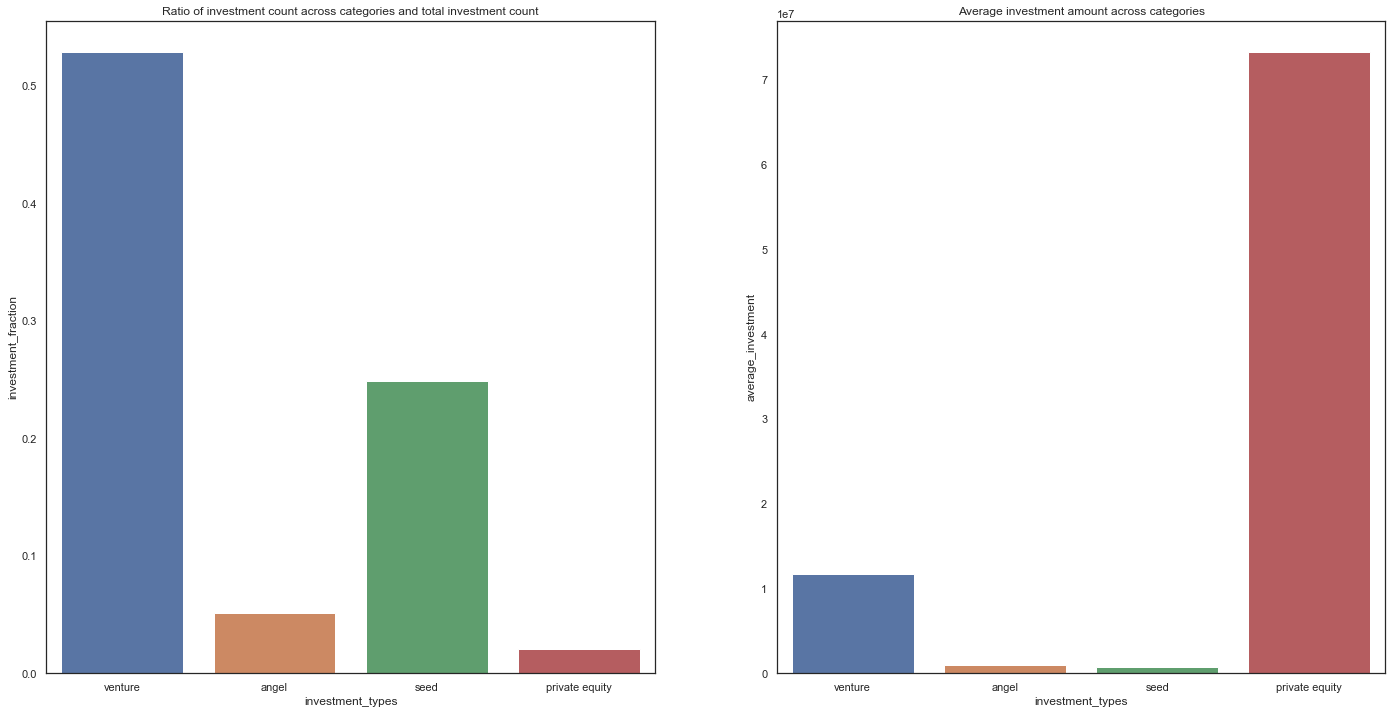

In [162]:
plot_1 = pd.DataFrame({'investment_fraction': [ventureInvCount/totalInvCount, angelInvCount/totalInvCount, seedInvCount/totalInvCount, peInvCount/totalInvCount],
                      'average_investment': [ventureAvg, angelAvg, seedAvg, peAvg],
                       'investment_types': ['venture','angel','seed','private equity']
                      })

# subplot 1: Ratio of investment count across categories and total investment count
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
sns.barplot(x='investment_types', y='investment_fraction', data=plot_1)
plt.title("Ratio of investment count across categories and total investment count")

# subplot 2: Average investment amount across categories
plt.subplot(1, 2, 2)
sns.barplot(x='investment_types', y='average_investment', data=plot_1)
plt.title("Average investment amount across categories")

plt.show()


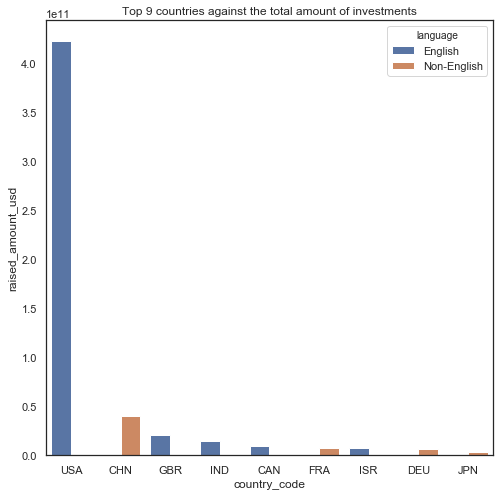

In [163]:
language = ["English", "Non-English", "English","English","English","Non-English","English","Non-English","Non-English"]
top9["language"] = language
top9 = top9.reset_index()
top9.head(9)

plt.figure(figsize=(8,8))
sns.barplot(x="country_code", y="raised_amount_usd", hue = 'language', data=top9)
plt.title("Top 9 countries against the total amount of investments")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

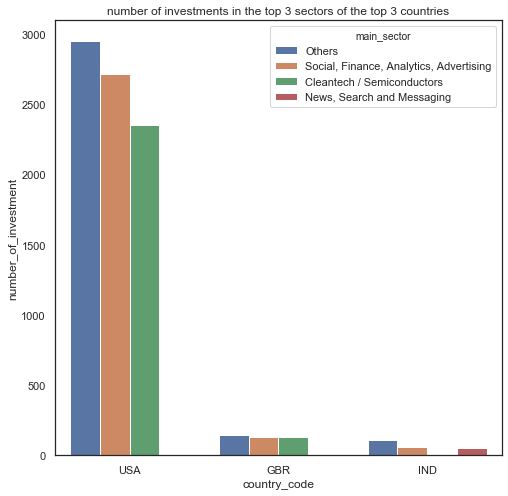

In [164]:
new_df = pd.DataFrame({'country_code': [C1,C1,C1,C2,C2,C2,C3,C3,C3],
              'main_sector': [first_sector_D1, second_sector_D1, third_sector_D1, first_sector_D2, second_sector_D2, third_sector_D2, first_sector_D3, second_sector_D3, third_sector_D3],
              'number_of_investment':[first_sector_D1_inv_count, second_sector_D1_inv_count, third_sector_D1_inv_count, first_sector_D2_inv_count, second_sector_D2_inv_count, third_sector_D2_inv_count, first_sector_D3_inv_count, second_sector_D3_inv_count, third_sector_D3_inv_count]})

plt.figure(figsize=(8,8))
sns.barplot(x="country_code", y="number_of_investment", hue = 'main_sector', data=new_df)
plt.title("number of investments in the top 3 sectors of the top 3 countries")
plt.show